In [35]:
import xmltodict, json, feedparser
from urllib.request import urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time, re
import pandas as pd
from collections import defaultdict
import json
from datetime import datetime
from datetime import date
from selenium.webdriver.common.by import By
from pprint import pprint
import dataframe_image as dfi
import os, sys
from PIL import Image
import cv2
from io import BytesIO
from zipfile import ZipFile
import xml.etree.ElementTree as ET
from ast import literal_eval
import requests
from dateutil.relativedelta import relativedelta
from urllib import parse
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib.dates as mdates

import ssl
context = ssl._create_unverified_context()

crtfc_key = '0a8c798b97ddd067012cb38f15aa6252a82d9f13'
url_corpcode = 'https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={}'.format(crtfc_key)

with urlopen(url_corpcode, context=context) as zip_response:
    with ZipFile(BytesIO(zip_response.read())) as zfile:
        zfile.extractall()

tree = ET.parse('corpcode.xml')
root = tree.getroot()

def find_stock_code(find_name):
    for company in root.iter('list'):                                                                          
        if company.findtext('corp_name') == find_name:
            if company.findtext('stock_code').isspace(): # None
                continue
            else:
                return company.findtext('stock_code')

In [19]:
def get_sise(code, start_time, end_time, time_from='day') :
        get_param = {
            'symbol':code,
            'requestType':1,
            'startTime':start_time,
            'endTime':end_time,
            'timeframe':time_from
        }
        get_param = parse.urlencode(get_param)
        url="https://api.finance.naver.com/siseJson.naver?%s"%(get_param)
        response = requests.get(url)
        return literal_eval(response.text.strip())

end = datetime.today().strftime('%Y%m%d')
start = (date.today() + relativedelta(months=-36)).strftime('%Y%m%d')

In [26]:
companyName = '피엔티'
stockCode = find_stock_code(companyName)
sise_list = get_sise(stockCode, start, end, 'day')
dfSise = pd.DataFrame(sise_list[1:], columns=sise_list[0])
dfSise.index = dfSise['날짜']
dfSise.index.name = 'Date'
dfSise.drop('날짜', axis=1, inplace=True)

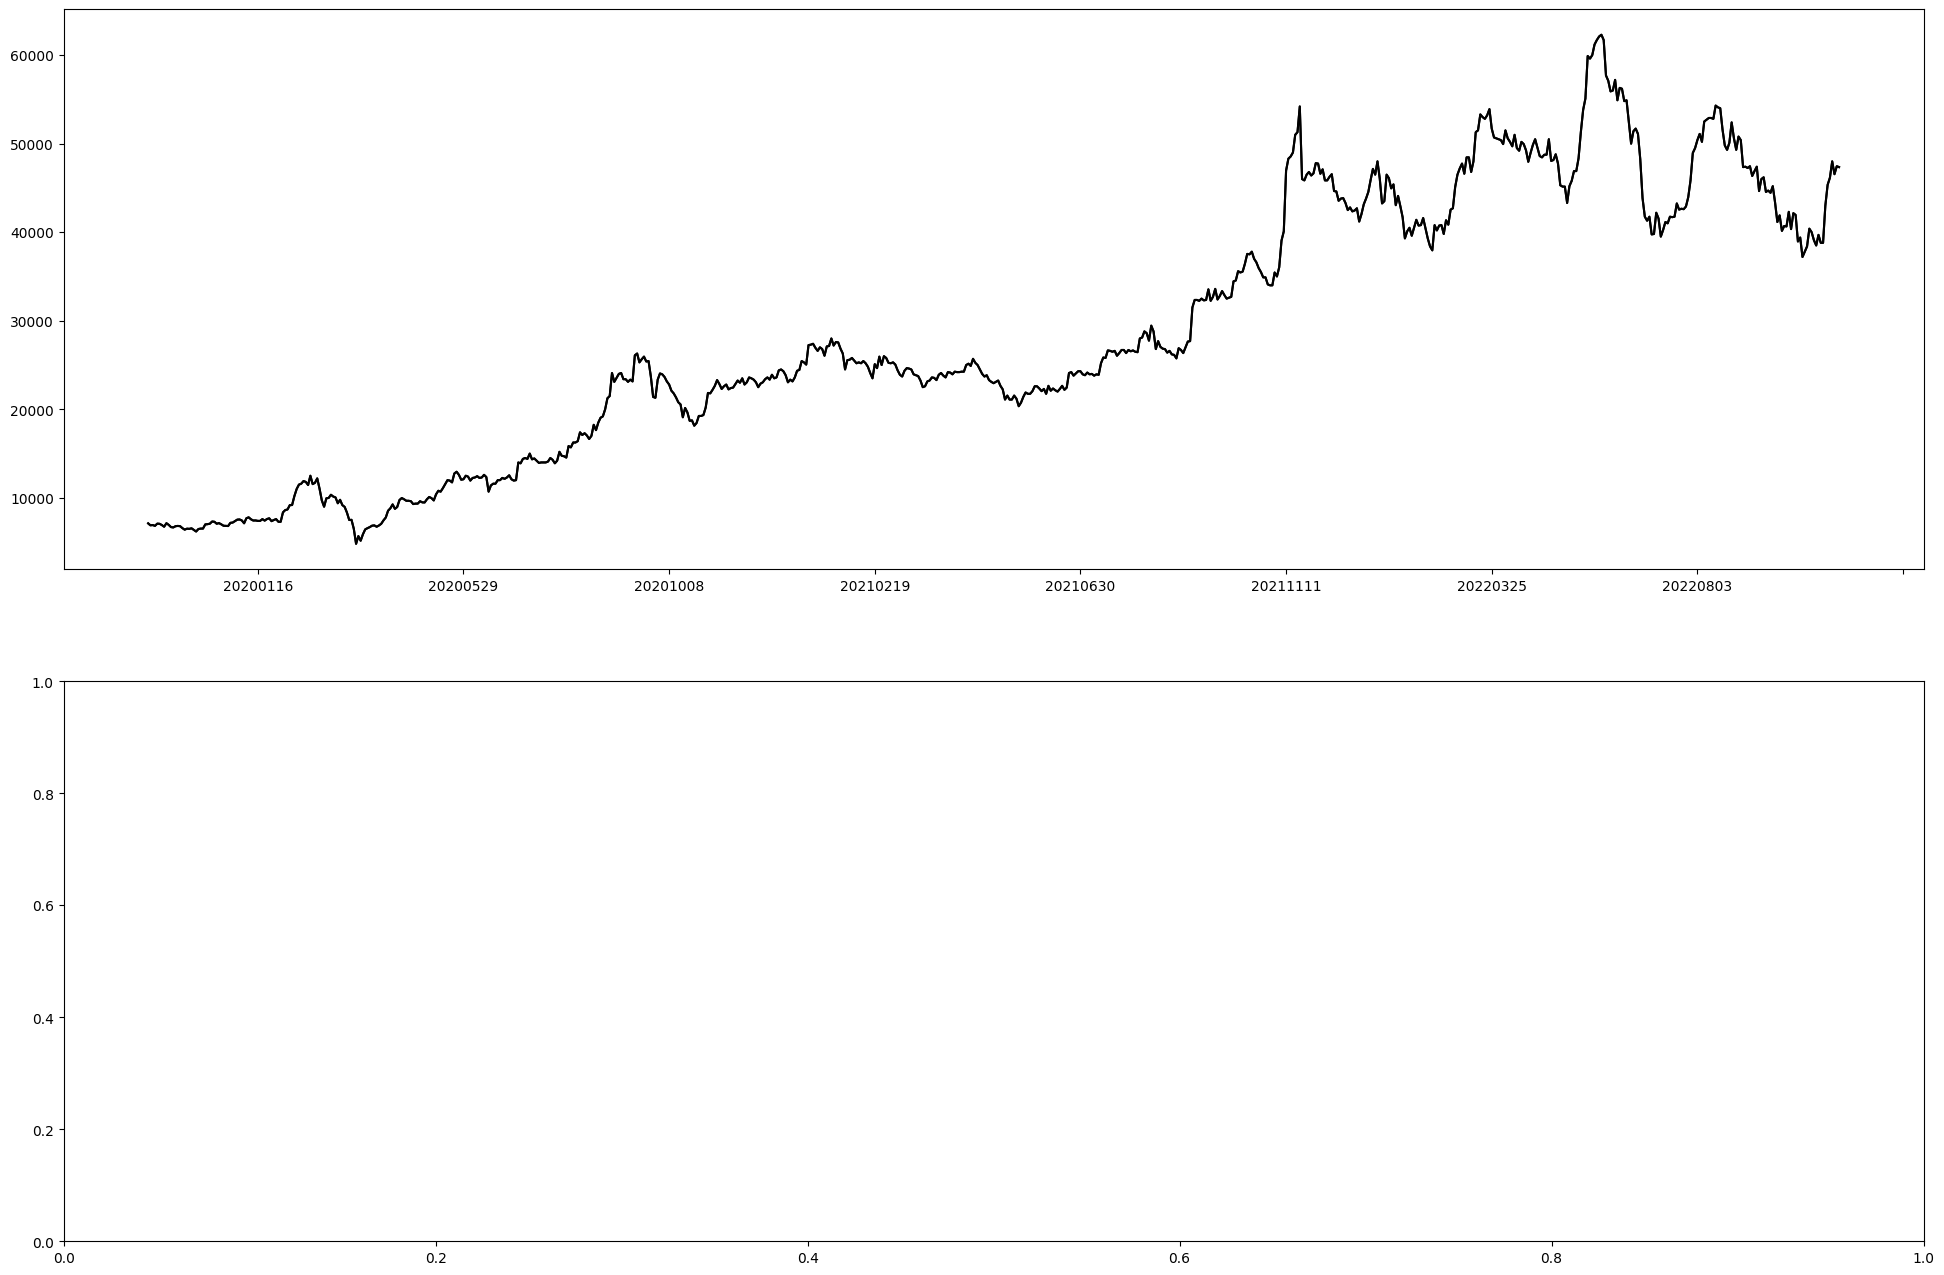

In [63]:
plt.rc('figure', figsize=(24, 16))
fig, (ax1, ax2) = plt.subplots(2, 1)
priceList = dfSise['종가'].to_numpy()
contractList = dfFinal['계약금액'].to_numpy()
ln1 = ax1.plot(dfSise.index, priceList, 'k-', label = 'price(L)')
ln2 = ax1.plot(dfFinal.index, priceList, 'k-', label = 'price(L)')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=90))


In [33]:
priceList

array([ 7120,  6900,  6930,  6840,  7090,  7070,  6930,  6740,  7140,
        6950,  6700,  6660,  6800,  6830,  6800,  6580,  6410,  6520,
        6500,  6560,  6380,  6200,  6480,  6530,  6530,  7000,  7030,
        7080,  7330,  7300,  7080,  7150,  7010,  6850,  6840,  6820,
        7180,  7210,  7380,  7540,  7560,  7450,  7130,  7700,  7800,
        7580,  7440,  7450,  7400,  7400,  7600,  7430,  7610,  7690,
        7370,  7500,  7600,  7300,  7300,  8360,  8620,  8690,  9180,
        9190, 10200, 11000, 11500, 11600, 11900, 11800, 11450, 12500,
       11550, 11700, 12200, 11050,  9720,  9000,  9950,  9990, 10350,
       10150, 10050,  9390,  9780,  9180,  8980,  8340,  7500,  7520,
        6510,  4810,  5680,  5160,  5890,  6440,  6580,  6700,  6860,
        6890,  6740,  6880,  7070,  7460,  7780,  8550,  8820,  9260,
        8760,  8970,  9760,  9980,  9840,  9670,  9670,  9620,  9300,
        9350,  9350,  9620,  9490,  9480,  9840, 10100,  9970,  9710,
       10400, 10800,

In [5]:
find_stock_code('피엔티')

'137400'

In [106]:
# 공급계약

title = '단일판매ㆍ공급계약체결'
link = 'https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20221020900156'
companyName = '제룡전기'
text = title
date = '2019-11-07'

if ('단일판매ㆍ공급계약체결' in title):  # and not('정정' in title):

  option = Options()
  option.add_argument('headless')
  driver = webdriver.Chrome(options=option)
  driver.get(link)
  # time.sleep(2)
  html_source = driver.page_source

  rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
  dcmNo = re.findall(r"', '(.*?)'\);", html_source)

  # url이 있어야 read_html을 통해 table 가져올 수 있다
  frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

  table_ifrm = pd.read_html(frame_url, index_col=1)

  for index, row in table_ifrm[0].iterrows():
    if '계약금액' in index:
      # contractAmount = f'{int(row[2]):,}'
      contractAmount = int(row[2])
      break
  for index, row in table_ifrm[0].iterrows():
    if '매출액' in index:
      latestSales = f'{int(row[2]):,}'
      break
  for index, row in table_ifrm[0].iterrows():
    if '%' in index:
      contractSalesRatio = f'{round(float(row[2]), 1):,}'
      break
  for index, row in table_ifrm[0].iterrows():
    if '상대방' in index:
      counterPart = row[2]
      break
  for index, row in table_ifrm[0].iterrows():
    if '시작' in index:
      beginningDay = row[2]
      break
  for index, row in table_ifrm[0].iterrows():
    if '종료' in index:
      endingDay = row[2]
      break
  
  beginningDay


In [107]:
dfSupply = pd.DataFrame([[date, contractAmount, latestSales, contractSalesRatio, beginningDay, endingDay]], columns=['날짜', '계약금액', '최근매출액', '매출액대비(%)', '시작일', '종료일'])
dfSupply.index = dfSupply['날짜']
dfSupply.index.name = 'Date'
dfSupply.index = pd.to_datetime(dfSupply.index, format = '%Y-%m-%d').strftime('%Y%m%d')
dfSupply.drop('날짜', axis=1, inplace=True)

# indexOpConsF = pd.to_datetime(indexOpConsF, format = '%Y-%m-%d').strftime('%Y%m%d')
# dfOpConsF.index = indexOpConsF

In [108]:
dfSupply

,계약금액,최근매출액,매출액대비(%),시작일,종료일
Date,,,,,
20191107,13382052000,"48,783,124,675",27.4,2022-10-20,2024-12-31


In [109]:
dfFinal = dfSise.join(dfSupply, how='left', on='Date').fillna(0)

In [110]:
dfFinal

,시가,고가,저가,종가,거래량,외국인소진율,계약금액,최근매출액,매출액대비(%),시작일,종료일
Date,,,,,,,,,,,
20191106,7330,7500,7040,7120,639938,1.35,0.000000e+00,0,0,0,0
20191107,7150,7150,6800,6900,501736,1.19,1.338205e+10,"48,783,124,675",27.4,2022-10-20,2024-12-31
20191108,6990,7100,6920,6930,288298,1.26,0.000000e+00,0,0,0,0
20191111,6930,6980,6790,6840,219765,1.37,0.000000e+00,0,0,0,0
20191112,6820,7130,6760,7090,298174,1.35,0.000000e+00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20221031,46800,47450,45500,46150,481178,8.68,0.000000e+00,0,0,0,0
20221101,45850,48000,45850,48000,392747,8.87,0.000000e+00,0,0,0,0
20221102,48000,48350,45850,46550,362927,8.76,0.000000e+00,0,0,0,0


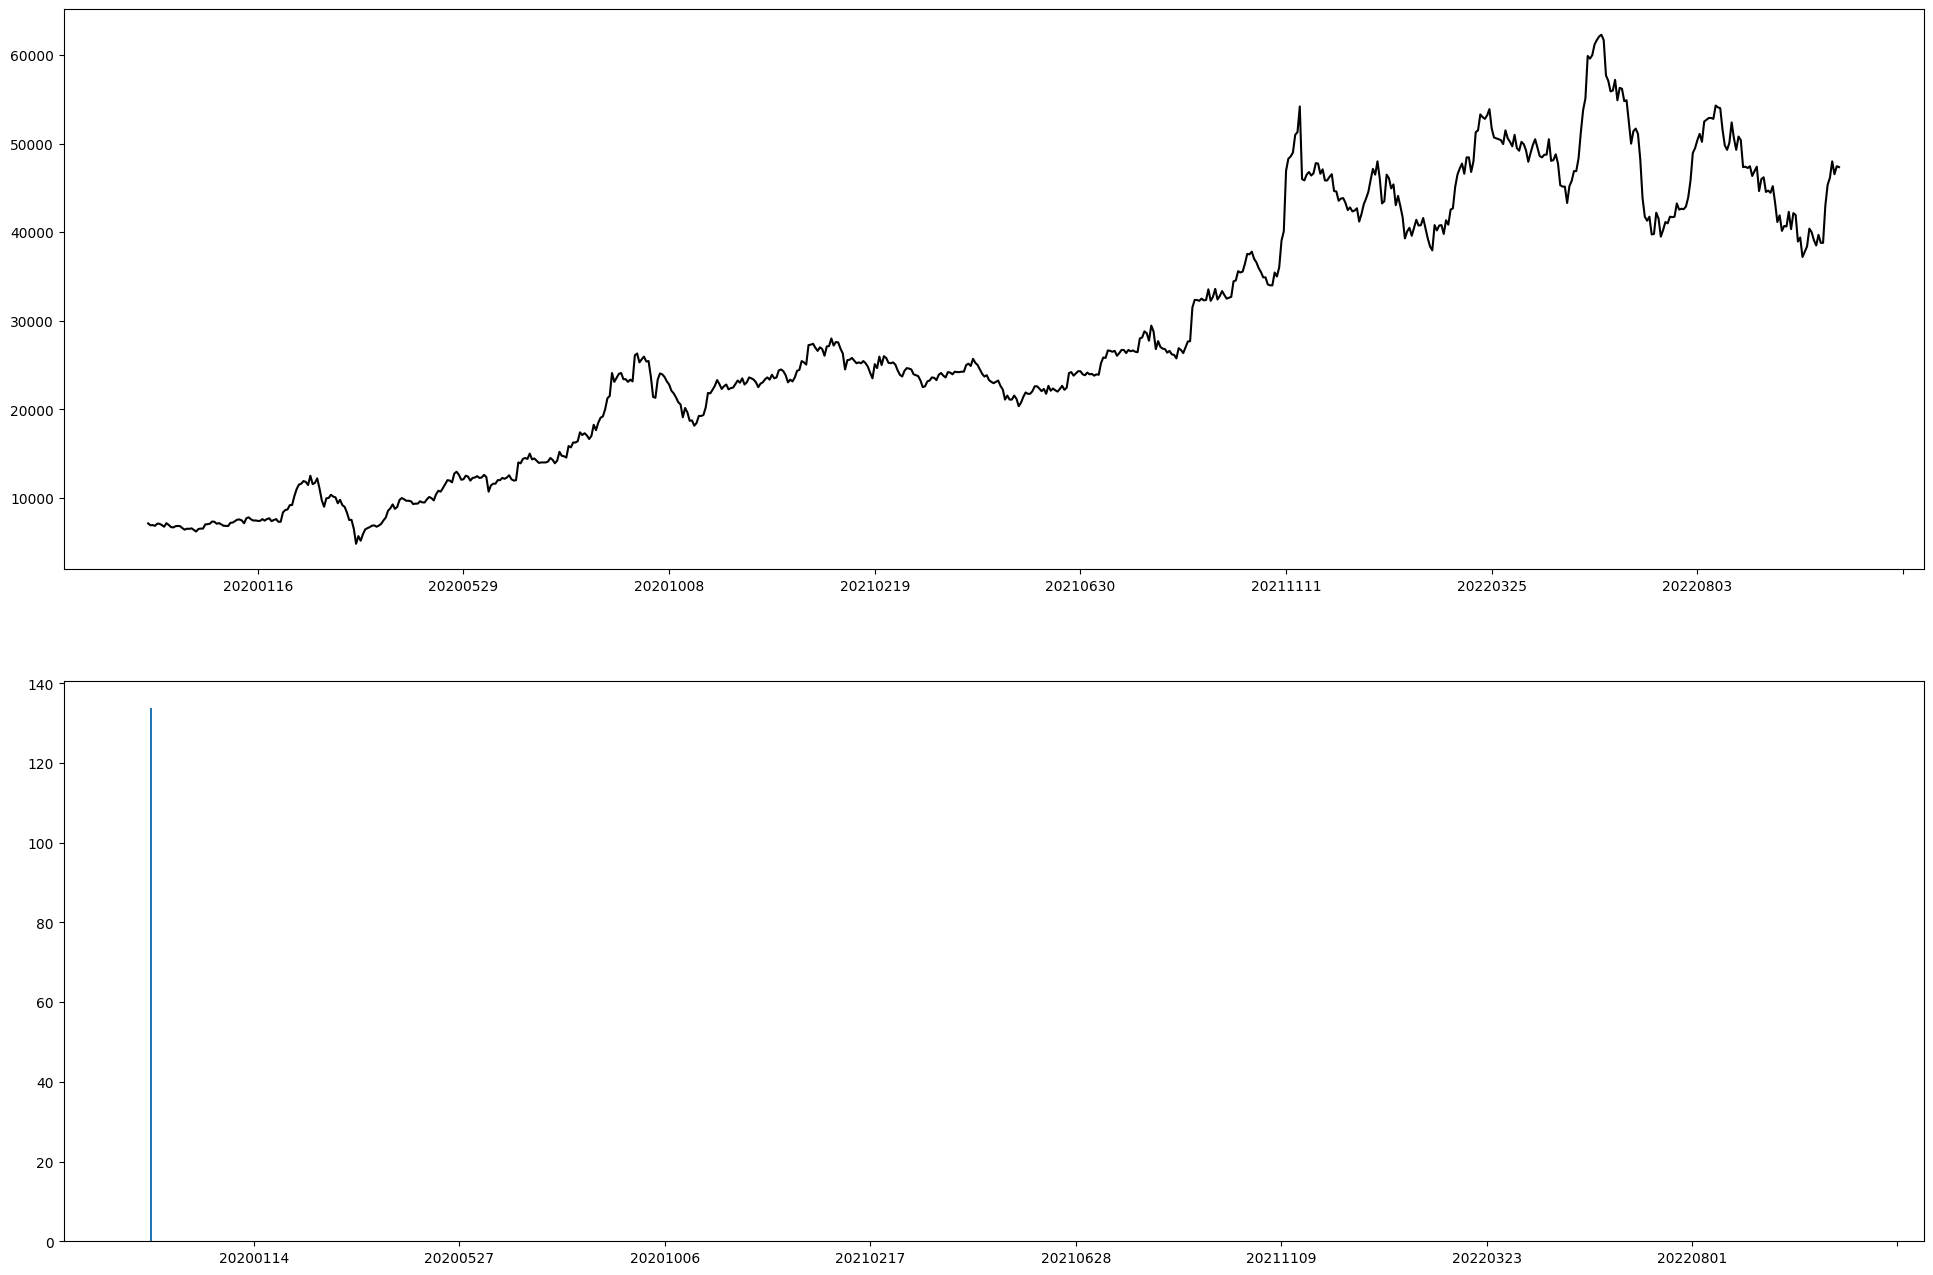

In [114]:
plt.rc('figure', figsize=(24, 16))
fig, (ax1, ax2) = plt.subplots(2, 1)
priceList = dfSise['종가'].to_numpy()
contractList = dfFinal['계약금액'].to_numpy()/100000000
ln1 = ax1.plot(dfSise.index, priceList, 'k-', label = 'price(L)')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=90))
ln2 = ax2.bar(dfFinal.index, contractList)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=90))

In [81]:
dfSupply.index

Index(['20191107'], dtype='object', name='Date')

In [105]:
contractList = dfFinal['계약금액'].to_numpy()
contractList

array([0, '13,382,052,000', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [60]:
td = date.fromisoformat(endingDay.replace("'",'')) - date.fromisoformat(beginningDay.replace("'",''))
td

AttributeError: 'str' object has no attribute 'fromisoformat'

In [30]:
table_ifrm[0]

,0,2,3
1,,,
1. 판매ㆍ공급계약 내용,1. 판매ㆍ공급계약 내용,IBC101 CAR-T 세포 제조 위수탁 계약,IBC101 CAR-T 세포 제조 위수탁 계약
조건부 계약여부,2. 계약내역,미해당,미해당
확정 계약금액,2. 계약내역,480000000,480000000
조건부 계약금액,2. 계약내역,-,-
계약금액 총액(원),2. 계약내역,480000000,480000000
최근 매출액(원),2. 계약내역,909090909,909090909
매출액 대비(%),2. 계약내역,52.8,52.8
3. 계약상대방,3. 계약상대방,(주)이노베이션바이오,(주)이노베이션바이오
-최근 매출액(원),-최근 매출액(원),0,0
